In [1]:
! pip install -q alphashape descartes shapely

In [2]:
import itertools
import math
import os
import re
import warnings

import alphashape
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from descartes import PolygonPatch
from IPython.display import Image
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
from pymoo.factory import get_performance_indicator
from scipy.spatial import Delaunay
from shapely.geometry import MultiLineString, MultiPoint, mapping
from shapely.ops import cascaded_union, polygonize
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')


In [3]:
colors = {
    'blue': '#1f77b4',
    'orange': '#ff7f0e',
    'green': '#2ca02c',
    'red': '#d62728',
    'purple': '#9467bd',
    'brown': '#8c564b',
    'pink': '#e377c2',
    'gray': '#7f7f7f',
    'olive': '#bcbd22',
    'cyan': '#17becf',
}


## Helper Methods

### Helper Methods - General

In [4]:
def frontier_builder(df, alpha=0, verbose=False):
    """
    Modified alphashape algorithm to draw Pareto Front for OFA search.
    Takes a DataFrame of column form [x, y] = [latency, accuracy]

    Params:
    df     - 2 column dataframe in order of 'Latency' and 'Accuracy'
    alpha  - Dictates amount of tolerable 'concave-ness' allowed.
             A fully convex front will be given if 0 (also better for runtime)    
    """
    if verbose:
        print('Running front builder')
    df = df[['Latency', 'Accuracy']]
    points = list(df.to_records(index=False))
    points = MultiPoint(list(points))

    if len(points) < 4 or (alpha is not None and alpha <= 0):
        if verbose:
            print('Alpha=0 -> convex hull')
        result = points.convex_hull
    else:
        coords = np.array([point.coords[0] for point in points])
        tri = Delaunay(coords)
        edges = set()
        edge_points = []
        edge_out = []

        # Loop over triangles
        for ia, ib, ic in tri.vertices:
            pa = coords[ia]
            pb = coords[ib]
            pc = coords[ic]

            # Lengths of sides of triangle
            a = math.sqrt((pa[0] - pb[0])**2 + (pa[1] - pb[1])**2)
            b = math.sqrt((pb[0] - pc[0])**2 + (pb[1] - pc[1])**2)
            c = math.sqrt((pc[0] - pa[0])**2 + (pc[1] - pa[1])**2)

            # Semiperimeter of triangle
            s = (a + b + c) * 0.5

            # Area of triangle by Heron's formula
            # Precompute value inside square root to avoid unbound math error in
            # case of 0 area triangles.
            area = s * (s - a) * (s - b) * (s - c)

            if area > 0:
                area = math.sqrt(area)

                # Radius Filter
                if a * b * c / (4.0 * area) < 1.0 / alpha:
                    for i, j in itertools.combinations([ia, ib, ic], r=2):
                        if (i, j) not in edges and (j, i) not in edges:
                            edges.add((i, j))
                            edge_points.append(coords[[i, j]])

                            if coords[i].tolist() not in edge_out:
                                edge_out.append(coords[i].tolist())
                            if coords[j].tolist() not in edge_out:
                                edge_out.append(coords[j].tolist())

        # Create the resulting polygon from the edge points
        m = MultiLineString(edge_points)
        triangles = list(polygonize(m))
        result = cascaded_union(triangles)

    # Find multi-polygon boundary
    bound = list(mapping(result.boundary)['coordinates'])

    # Cutoff non-Pareto front points
    # note that extreme concave geometries will create issues if bi-sected by line
    df = pd.DataFrame(bound, columns=['x', 'y'])

    # y=mx+b
    left_point = (df.iloc[df.idxmin()[0]][0], df.iloc[df.idxmin()[0]][1])
    right_point = (df.iloc[df.idxmax()[1]][0], df.iloc[df.idxmax()[1]][1])
    m = (left_point[1]-right_point[1])/(left_point[0]-right_point[0])
    b = left_point[1]-(m*left_point[0])

    df = df[df['y'] >= (m*df['x']+b)]
    df.sort_values(by='x', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Cleanup - insure accuracy is always increasing with latency up the Pareto front
    best_acc = 0
    drop_list = []
    for i in range(len(df)):
        if df.iloc[i]['y'] > best_acc:
            best_acc = df.iloc[i]['y']
        else:
            drop_list.append(i)
    df.drop(df.index[drop_list], inplace=True)
    df.reset_index(drop=True, inplace=True)

    df.columns = ['Latency', 'Accuracy']

    return df


def load_csv(filepath, col_list=['build', 'date', 'Latency', 'Accuracy'],
                  add_build=False, normalize=False, idx_slicer=None,
                  fit=False, scaler=None, sort=False, verbose=False):
    if idx_slicer is not None:
        df = pd.read_csv(filepath, names=col_list).iloc[:idx_slicer]
    else:
        df = pd.read_csv(filepath, names=col_list)
        
    if sort:
        df = df.sort_values(by=['Latency']).reset_index(drop=True)
    if verbose:
        print(filepath)
        print('dataset length: {}'.format(len(df)))
        print('acc max = {}'.format(df['Accuracy'].max()))
        print('lat min = {}'.format(df['Latency'].min()))

    if add_build:
        df = df[['build', 'Latency', 'Accuracy']]
    else:
        df = df[['Latency', 'Accuracy']]

    if normalize:
        if fit == True:
            scaler = MinMaxScaler()
            scaler.fit(df['Latency'].values.reshape(-1, 1))
            df['Latency'] = scaler.transform(df['Latency'].values.reshape(-1, 1)).squeeze()
            return df, scaler
        else:
            df['Latency'] = scaler.transform(df['Latency'].values.reshape(-1, 1)).squeeze()
            return df
    else:
        return df


def natural_sort(l):
    def convert(text): return int(text) if text.isdigit() else text.lower()
    def alphanum_key(key): return [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)


def collect_hv(supernet):
    start_interval = np.array(list(range(10, 200, 10)))
    end_interval = np.array(list(range(200, 10000, 100)))
    full_interval = np.concatenate([start_interval, end_interval])
    hv_list = list()
    
    for evals in tqdm.tqdm(full_interval):
    
        front = frontier_builder(supernet.iloc[:evals])
        front['nAccuracy'] = -front['Accuracy']
    
        hv_list.append(hv.do(front[['Latency','nAccuracy']].values))
     
    for i in range(0, len(hv_list)-1):
        if hv_list[i+1] < hv_list[i]:
            hv_list[i+1] = hv_list[i]
    
    full_interval = np.insert(full_interval, 0, 1, axis=0)
    hv_list=np.array(hv_list)
    hv_list = np.insert(hv_list, 0, 0, axis=0)
    
    return hv_list, full_interval

## Load Data

### Load Data - General

In [5]:
SEARCH_SPACE = 'r50'  # 'r50', 'hat', 'ncf'
NORMALIZE = True  # If True latency and hypervolume will be normalized
PLOT_HYPERVOLUME = True


if 'r50' in SEARCH_SPACE:
    plot_subtitle = 'BootstrapNAS ResNet50, ICX 8380, BS1, Evaluations {step} ({samples}/{evaluations}) @ Time elapsed: {elapsed_h}h{elapsed_m}m'
    save_dir = 'output/bnas_linas_icx_bs1/'
    population = 50
    EVALUATIONS = 200
    xlim = None
    ylim = (73.0, 77.5)
    avg_time = 5.9
    ref_x = [1.08]
    ref_y = [76.05]

    if NORMALIZE:
        df_linas, scaler = load_csv('example_data/r50_icx8380_bs1/linas_s1_567255dbd06d.csv', normalize=True, fit=True, idx_slicer=EVALUATIONS)
        df_nsga = load_csv('example_data/r50_icx8380_bs1/full_s1_452dbdef624a.csv', normalize=True, scaler=scaler, idx_slicer=EVALUATIONS)
        df_random = load_csv('example_data/r50_icx8380_bs1/random_s1_297bdb736d80.csv', normalize=True, scaler=scaler, idx_slicer=EVALUATIONS)
        xlabel = 'Latency (normalized)'

        ref_x = scaler.transform(np.array([ref_x]).reshape(-1, 1)).squeeze()
    else:
        df_linas = load_csv('example_data/r50_icx8380_bs1/linas_s1_567255dbd06d.csv', normalize=False, idx_slicer=EVALUATIONS)
        df_nsga = load_csv('example_data/r50_icx8380_bs1/full_s1_452dbdef624a.csv', normalize=False, idx_slicer=EVALUATIONS)
        df_random = load_csv('example_data/r50_icx8380_bs1/random_s1_297bdb736d80.csv', normalize=False, idx_slicer=EVALUATIONS)
        xlabel = 'Latency (ms)'

    df_linas_front = frontier_builder(df_linas)
    df_nsga_front = frontier_builder(df_nsga)


if 'ncf' in SEARCH_SPACE:
    plot_subtitle = 'Recommendation, CLX 8280, Evaluations {step} ({samples}/{evaluations}) @ Time elapsed: {elapsed_h}h{elapsed_m}m'
    save_dir = 'output/ncf_clx/'
    population = 20
    EVALUATIONS = 80
    xlim = (0.0, 3.0)
    ylim = (0.845, 0.866)
    avg_time = 3.02

    if NORMALIZE:
        df_random, scaler = load_csv('example_data/ncf_clx8280/random_search_seed1.csv', normalize=True, fit=True, idx_slicer=EVALUATIONS)
        df_linas = load_csv('example_data/ncf_clx8280/ncf_linas_loop40_concurrent_search_seed1.csv', normalize=True, scaler=scaler, idx_slicer=EVALUATIONS)
        df_nsga = load_csv('example_data/ncf_clx8280/full_search_seed1.csv', normalize=True, scaler=scaler, idx_slicer=EVALUATIONS)
        
        xlim = None
        xlabel = 'Latency (normalized)'
    else:
        df_linas = load_csv('example_data/ncf_clx8280/ncf_linas_loop40_concurrent_search_seed1.csv', normalize=False, idx_slicer=EVALUATIONS)
        df_nsga = load_csv('example_data/ncf_clx8280/full_search_seed1.csv', normalize=False, idx_slicer=EVALUATIONS)
        df_random = load_csv('example_data/ncf_clx8280/random_search_seed1.csv', normalize=False, idx_slicer=EVALUATIONS)
        xlabel = 'Latency (ms)'

    df_linas_front = frontier_builder(df_linas)
    df_nsga_front = frontier_builder(df_nsga)


if 'hat' in SEARCH_SPACE:
    plot_subtitle = 'Translation, CLX 8280, Evaluations {step} ({samples}/{evaluations}) @ Time elapsed: {elapsed_h}h{elapsed_m}m'
    save_dir = 'output/hat_clx/'
    population = 50
    EVALUATIONS = 200
    xlim = None
    ylim = None
    avg_time = 3.2

    if NORMALIZE:
        df_linas, scaler = load_csv('example_data/hat_clx8280/linas_hat.csv', normalize=True, fit=True, idx_slicer=EVALUATIONS)
        df_nsga = load_csv('example_data/hat_clx8280/fullsearch_hat.csv', normalize=True, scaler=scaler, idx_slicer=EVALUATIONS)
        df_random = load_csv('example_data/hat_clx8280/random_search_750evals.csv', normalize=True, scaler=scaler, idx_slicer=EVALUATIONS)
        xlabel = 'Latency (normalized)'
    else:
        df_linas = load_csv('example_data/hat_clx8280/linas_hat.csv', normalize=False, idx_slicer=EVALUATIONS)
        df_nsga = load_csv('example_data/hat_clx8280/fullsearch_hat.csv', normalize=False, idx_slicer=EVALUATIONS)
        df_random = load_csv('example_data/hat_clx8280/random_search_750evals.csv', normalize=False, idx_slicer=EVALUATIONS)
        xlabel = 'Latency (ms)'

    df_linas_front = frontier_builder(df_linas)
    df_nsga_front = frontier_builder(df_nsga)



In [6]:
if PLOT_HYPERVOLUME:
    evals_list = np.array(list(range(10, 10000, 10)))
    ref_point = [120, -72]  # latency, -top1
    hv = get_performance_indicator("hv", ref_point=np.array(ref_point))
    edge_points = []

    # LINAS
    # For single run use (NOTE: the std won't be plotted with a single run):
    # hv_seed1, interval = collect_hv(df_linas)

    # For multiple runs (NOTE: Remember to vstack all runs from a given search):
    df_seed1 = load_csv('example_data/r50_icx8380_bs1/linas_s1_567255dbd06d.csv', idx_slicer=EVALUATIONS)
    hv_seed1, interval = collect_hv(df_seed1)
    df_seed2 = load_csv('example_data/r50_icx8380_bs1/linas_s2_4cdea13f9bb0.csv', idx_slicer=EVALUATIONS)
    hv_seed2, _ = collect_hv(df_seed2)
    df_seed3 = load_csv('example_data/r50_icx8380_bs1/linas_s3_4383be3a2293.csv', idx_slicer=EVALUATIONS)
    hv_seed3, _ = collect_hv(df_seed3)
    df_seed4 = load_csv('example_data/r50_icx8380_bs1/linas_s4_6a4f1721b4d3.csv', idx_slicer=EVALUATIONS)
    hv_seed4, _ = collect_hv(df_seed4)

    df_linas_hv = pd.DataFrame(np.vstack((hv_seed1, hv_seed2, hv_seed3, hv_seed4)).T)  # Stack all runs from a given search
    df_linas_hv['mean'] = df_linas_hv.mean(axis=1)
    df_linas_hv['std'] = df_linas_hv.std(axis=1)/3**0.5
    edge_points.append(min(df_linas_hv['mean'][population:] - df_linas_hv['std'][population:]))
    edge_points.append(max(df_linas_hv['mean'][population:] + df_linas_hv['std'][population:]))

    # RANDOM
    # hv_seed1, interval = collect_hv(df_random)
    df_seed1 = load_csv('example_data/r50_icx8380_bs1/random_s1_297bdb736d80.csv', idx_slicer=EVALUATIONS)
    hv_seed1, interval = collect_hv(df_seed1)
    df_seed2 = load_csv('example_data/r50_icx8380_bs1/random_s2_e0d87142b131.csv', idx_slicer=EVALUATIONS)
    hv_seed2, _ = collect_hv(df_seed2)
    df_seed3 = load_csv('example_data/r50_icx8380_bs1/random_s3_9ce0d92c62b5.csv', idx_slicer=EVALUATIONS)
    hv_seed3, _ = collect_hv(df_seed3)
    df_seed4 = load_csv('example_data/r50_icx8380_bs1/random_s4_00c880275c47.csv', idx_slicer=EVALUATIONS)
    hv_seed4, _ = collect_hv(df_seed4)

    df_rand_hv = pd.DataFrame(np.vstack((hv_seed1, hv_seed2, hv_seed3, hv_seed4)).T)
    df_rand_hv['mean'] = df_rand_hv.mean(axis=1)
    df_rand_hv['std'] = df_rand_hv.std(axis=1)/3**0.5
    edge_points.append(min(df_rand_hv['mean'][population:] - df_rand_hv['std'][population:]))
    edge_points.append(max(df_rand_hv['mean'][population:] + df_rand_hv['std'][population:]))

    # FULL
    # hv_seed1, interval = collect_hv(df_nsga)
    df_seed1 = load_csv('example_data/r50_icx8380_bs1/full_s1_452dbdef624a.csv', idx_slicer=EVALUATIONS)
    hv_seed1, interval = collect_hv(df_seed1)
    df_seed2 = load_csv('example_data/r50_icx8380_bs1/full_s2_b256befa0cda.csv', idx_slicer=EVALUATIONS)
    hv_seed2, _ = collect_hv(df_seed2)
    df_seed3 = load_csv('example_data/r50_icx8380_bs1/full_s3_672b1196b29b.csv', idx_slicer=EVALUATIONS)
    hv_seed3, _ = collect_hv(df_seed3)
    df_seed4 = load_csv('example_data/r50_icx8380_bs1/full_s4_c7d14f82fc49.csv', idx_slicer=EVALUATIONS)
    hv_seed4, _ = collect_hv(df_seed4)

    df_full_hv = pd.DataFrame(np.vstack((hv_seed1, hv_seed2, hv_seed3, hv_seed4)).T)
    df_full_hv['mean'] = df_full_hv.mean(axis=1)
    df_full_hv['std'] = df_full_hv.std(axis=1)/3**0.5
    edge_points.append(min(df_full_hv['mean'][population:] - df_full_hv['std'][population:]))
    edge_points.append(max(df_full_hv['mean'][population:] + df_full_hv['std'][population:]))

    ylim_hv = (min(edge_points)-0.05*min(edge_points), max(edge_points)+0.05*min(edge_points))

    if NORMALIZE:
        max_hv = max(edge_points)
        df_linas_hv['mean'] = df_linas_hv['mean'] / max_hv
        df_linas_hv['std'] = df_linas_hv['std'] / max_hv
        df_full_hv['mean'] = df_full_hv['mean'] / max_hv
        df_full_hv['std'] = df_full_hv['std'] / max_hv
        df_rand_hv['mean'] = df_rand_hv['mean'] / max_hv
        df_rand_hv['std'] = df_rand_hv['std'] / max_hv

        ylim_hv = (ylim_hv[0]/max_hv, ylim_hv[1]/max_hv)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 119.96it/s]


## Series of plots

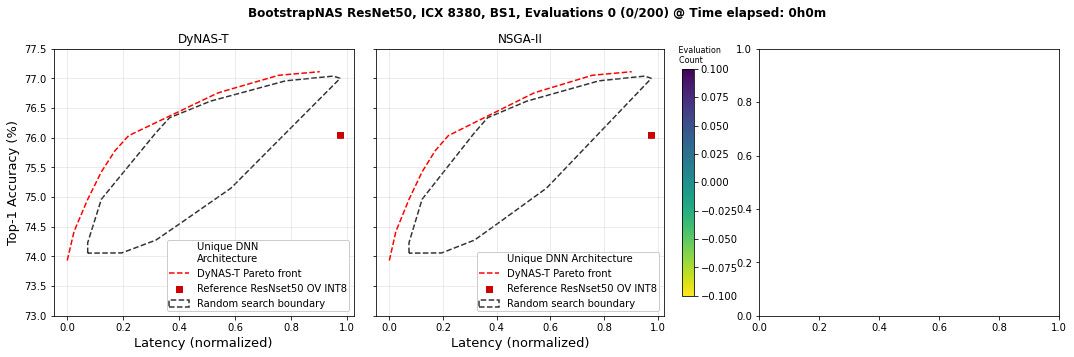

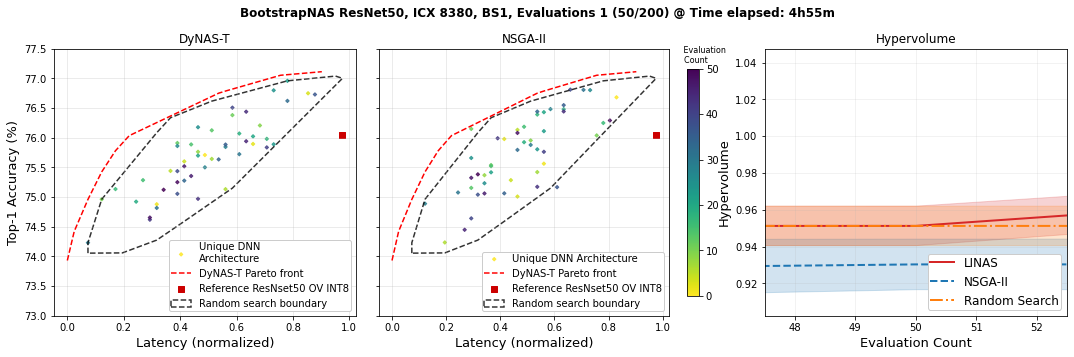

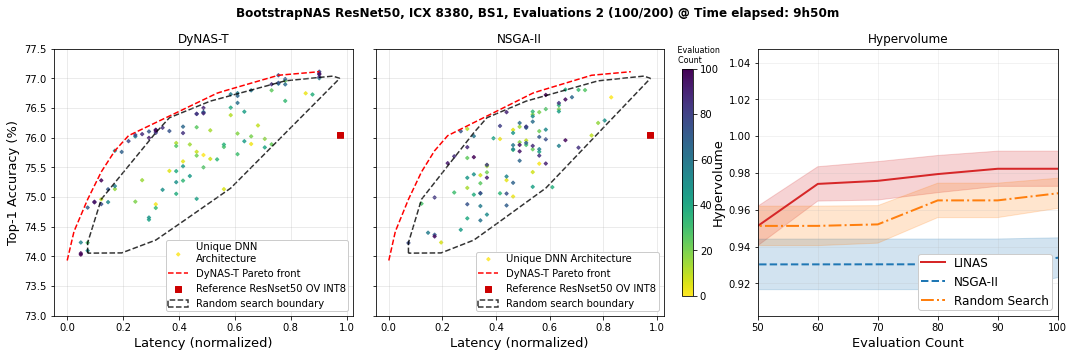

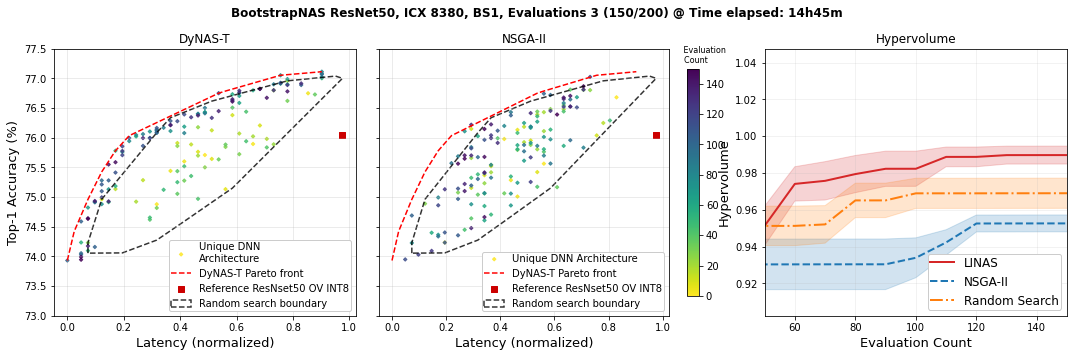

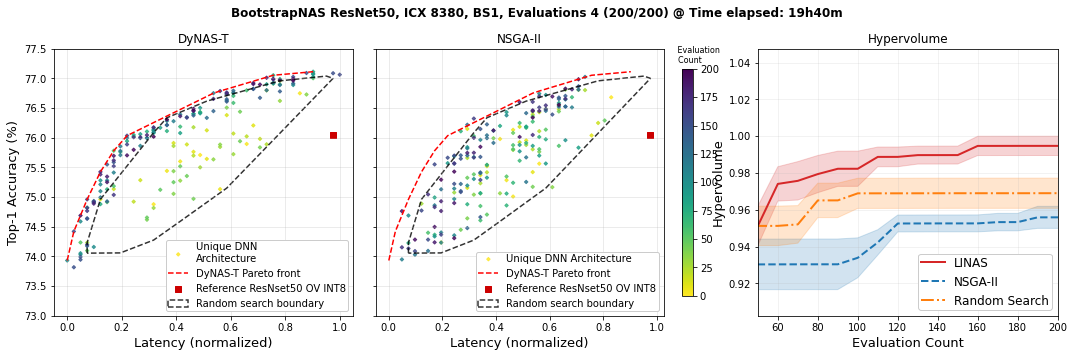

In [7]:
! rm -Rf $save_dir
os.makedirs(save_dir, exist_ok=True)


for samples in range(0, EVALUATIONS+1, population):
    elapsed_total_m = avg_time*samples
    elapsed_h = int(elapsed_total_m//60)
    elapsed_m = int(elapsed_total_m-(elapsed_h*60))
    if PLOT_HYPERVOLUME:
        fig, ax = plt.subplots(1, 3, figsize=(15,5), gridspec_kw={'width_ratios': [2.5, 3, 2.5]})
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': [2.5, 3.0]})
    fig.suptitle(plot_subtitle.format(step=samples//population, samples=samples, evaluations=EVALUATIONS, elapsed_h=elapsed_h, elapsed_m=elapsed_m),
        fontweight ="bold")
    cm = plt.cm.get_cmap('viridis_r')

    # LINAS plot
    df_conc = df_linas
    df_conc_front = df_linas_front
    data=df_conc[:samples][['Latency', 'Accuracy']]
    count = [x for x in range(len(data))]
    x = data['Latency']
    y = data['Accuracy']

    ax[0].set_title('DyNAS-T')
    ax[0].scatter(x, y, marker='D', alpha=0.8, c=count, cmap=cm, label='Unique DNN\nArchitecture', s=6)
    ax[0].set_ylabel('Top-1 Accuracy (%)', fontsize=13)
    ax[0].plot(df_conc_front['Latency'], df_conc_front['Accuracy'], 
               color='red', linestyle='--', label='DyNAS-T Pareto front')
    ax[0].scatter(ref_x, ref_y, marker='s', color='#c00', label='Reference ResNset50 OV INT8')

    # NSGA-II plot
    data1=df_nsga[:samples][['Latency', 'Accuracy']]
    count = [x for x in range(len(data1))]
    x = data1['Latency']
    y = data1['Accuracy']

    ax[1].set_title('NSGA-II')
    ax[1].scatter(x, y, marker='D', alpha=0.8, c=count, cmap=cm, label='Unique DNN Architecture', s=6)

    ax[1].get_yaxis().set_ticklabels([])
    ax[1].plot(df_conc_front['Latency'], df_conc_front['Accuracy'], 
               color='red', linestyle='--', label='DyNAS-T Pareto front')
    ax[1].scatter(ref_x, ref_y, marker='s', color='#c00', label='Reference ResNset50 OV INT8')


    cloud = list(df_random[['Latency','Accuracy']].to_records(index=False))
    alpha_shape = alphashape.alphashape(cloud, 0)


    for ax in fig.get_axes()[:2]:
        ax.add_patch(PolygonPatch(alpha_shape, fill=None, alpha=0.8, linewidth=1.5, label='Random search boundary', linestyle='--'))


        ax.legend(fancybox=True, fontsize=10, framealpha=1, borderpad=0.2, loc='lower right')
        if ylim:
            ax.set_ylim(ylim)
        if xlim:
            ax.set_xlim(xlim)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel(xlabel, fontsize=13)
    
    if PLOT_HYPERVOLUME and samples >= population:
        fig.get_axes()[2].set_title('Hypervolume')

        ########## LINAS
        fig.get_axes()[2].plot(interval, df_linas_hv['mean'], label='LINAS', color=colors['red'], linewidth=2)
        fig.get_axes()[2].fill_between(interval, df_linas_hv['mean']-df_linas_hv['std'], df_linas_hv['mean']+df_linas_hv['std'],  
                        color=colors['red'], alpha=0.2)
        ########## NSGA / FULL
        fig.get_axes()[2].plot(interval, df_full_hv['mean'], label='NSGA-II', linestyle='--', color=colors['blue'], linewidth=2)
        fig.get_axes()[2].fill_between(interval, df_full_hv['mean']-df_full_hv['std'], df_full_hv['mean']+df_full_hv['std'],  
                        color=colors['blue'], alpha=0.2)
        ########## RANDOM
        fig.get_axes()[2].plot(interval, df_rand_hv['mean'], label='Random Search', linestyle='-.', color=colors['orange'], linewidth=2)
        fig.get_axes()[2].fill_between(interval, df_rand_hv['mean']-df_rand_hv['std'], df_rand_hv['mean']+df_rand_hv['std'],  
                        color=colors['orange'], alpha=0.2)
        ##########

        fig.get_axes()[2].set_xlim(population, samples)
        if ylim_hv:
            fig.get_axes()[2].set_ylim(ylim_hv)

        fig.get_axes()[2].set_xlabel('Evaluation Count', fontsize=13)
        fig.get_axes()[2].set_ylabel('Hypervolume', fontsize=13)
        fig.get_axes()[2].legend(fancybox=True, fontsize=12, framealpha=1, borderpad=0.2, loc='lower right')

        fig.get_axes()[2].grid(True, alpha=0.2)


        formatter = ScalarFormatter()
        formatter.set_scientific(False)
        fig.get_axes()[2].xaxis.set_major_formatter(formatter)
    
    # Eval Count bar
    norm = plt.Normalize(0, len(data))
    sm = ScalarMappable(norm=norm, cmap=cm)
    cbar = fig.colorbar(sm, ax=ax, shrink=0.85)
    cbar.ax.set_title("         Evaluation\n  Count", fontsize=8)
    
    fig.tight_layout(pad=1)
    plt.subplots_adjust(wspace=0.07, hspace=0)
    plt.show();
    fn = save_dir + '/pareto_{}.png'.format(samples//population)
    ! rm -Rf $fn
    fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150);


## Animate!

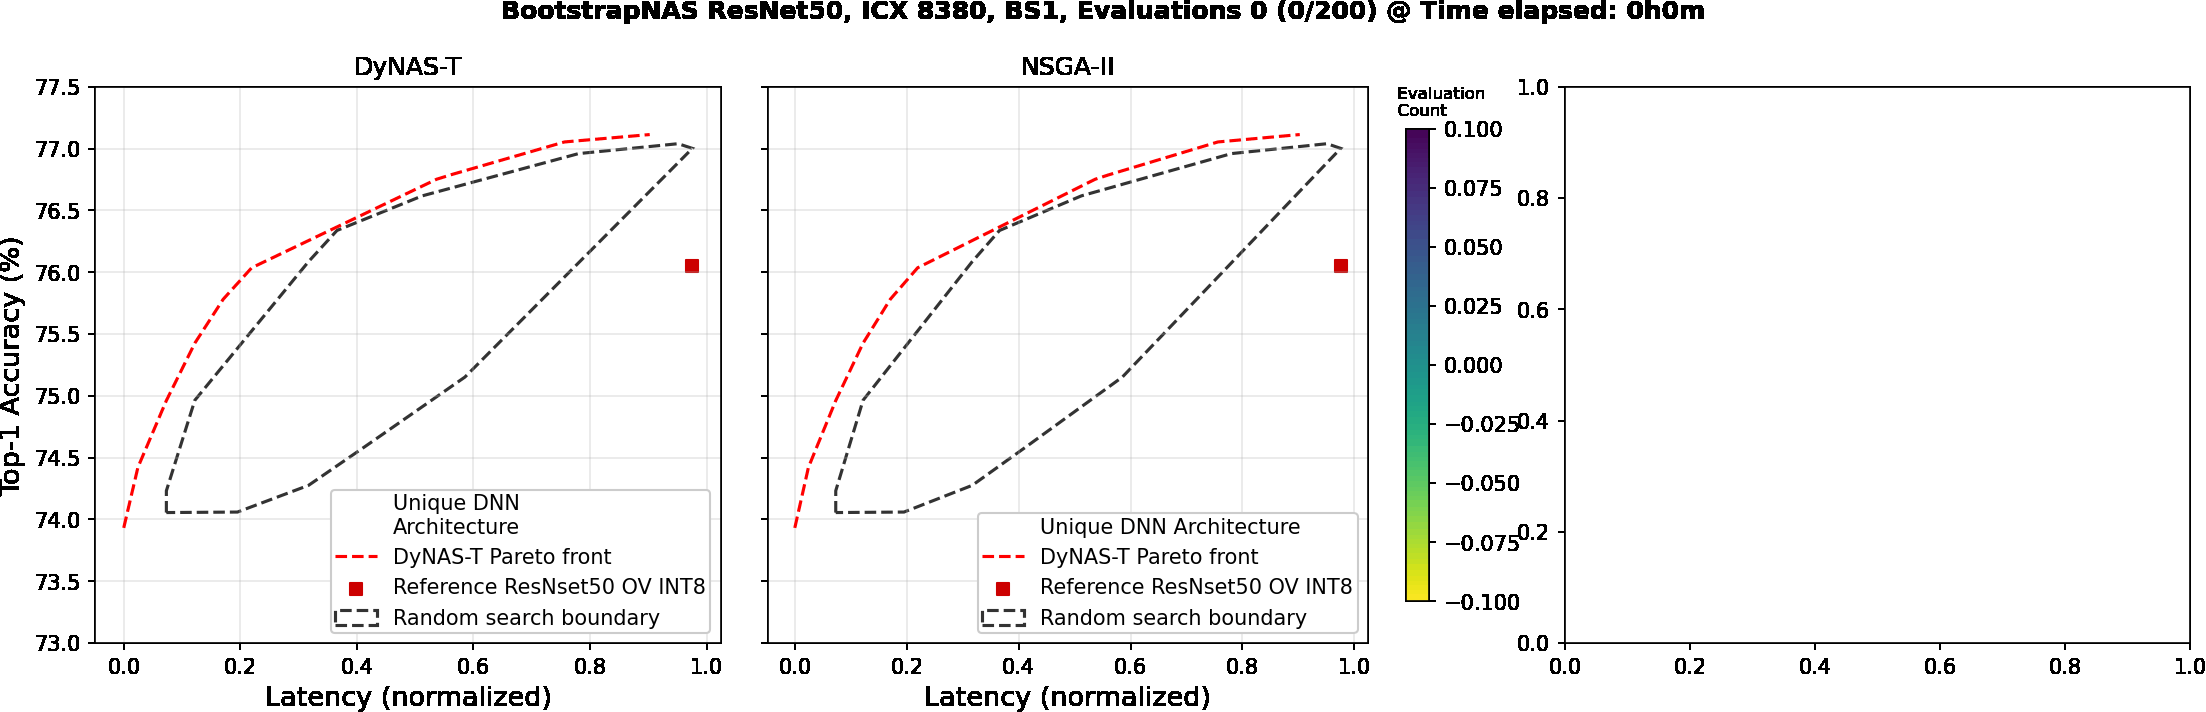

In [8]:
with imageio.get_writer(os.path.join(save_dir, 'pareto.gif'), mode='I', fps=0.75) as writer:
    for filename in [os.path.join(save_dir, f) for f in natural_sort(os.listdir(save_dir)) if f.endswith('.png')]:
        image = imageio.imread(filename)
        writer.append_data(image)
Image(filename=os.path.join(save_dir, 'pareto.gif')) 